# Instruções

Utilize o terminal ou um Anaconda Prompt e siga os passos a seguir

In [86]:
import joblib
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
conn_df = pd.read_csv('conexoes_espec.csv', sep=';')

In [3]:
conn_df.head(10)

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
5,3,7,familia,visita_casual,0.709608
6,4,8,familia,mora_junto,NaN
7,4,9,amigos,visita_casual,0.465209
8,5,10,trabalho,visita_frequente,0.658706
9,5,11,trabalho,visita_casual,NaN


In [4]:
conn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   V1           999999 non-null  int64  
 1   V2           999999 non-null  int64  
 2   grau         999999 non-null  object 
 3   proximidade  999999 non-null  object 
 4   prob_V1_V2   499999 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 38.1+ MB


In [5]:
conn_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
V1,999999.0,NaN,NaN,NaN,250000.25,144337.495129,1.0,125000.5,250000.0,375000.0,500000.0
V2,999999.0,NaN,NaN,NaN,500001.0,288674.990255,2.0,250001.5,500001.0,750000.5,1000000.0
grau,999999,3,trabalho,333548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proximidade,999999,4,visita_rara,400238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prob_V1_V2,499999.0,NaN,NaN,NaN,0.485162,0.173963,0.074462,0.351677,0.486413,0.61821,0.942245


In [6]:
conn_df['grau'].unique()

array(['trabalho', 'amigos', 'familia'], dtype=object)

In [7]:
conn_df['proximidade'].unique()

array(['visita_frequente', 'visita_rara', 'visita_casual', 'mora_junto'],
      dtype=object)

In [8]:
# rev_conn_df = conn_df[['V2', 'V1', 'grau', 'proximidade']].copy(deep=True).rename(columns={'V1': 'V2', 'V2': 'V1'})
# rev_conn_df['prob_V1_V2'] = np.nan

# conn_df['is_collected'] = True
# rev_conn_df['is_collected'] = False

# conn_df = conn_df.append(rev_conn_df, ignore_index=True) 

In [9]:
conn_df

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
...,...,...,...,...,...
999994,499998,999996,trabalho,visita_rara,NaN
999995,499998,999997,trabalho,visita_rara,NaN
999996,499999,999998,familia,visita_casual,0.451662
999997,499999,999999,familia,visita_rara,0.186973


In [10]:
ind_df = pd.read_csv('individuos_espec.csv', sep=';')

In [11]:
ind_df.head()

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668


In [12]:
ind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   name                       1000000 non-null  int64  
 1   idade                      904063 non-null   float64
 2   estado_civil               949927 non-null   object 
 3   qt_filhos                  971133 non-null   float64
 4   estuda                     959870 non-null   float64
 5   trabalha                   993647 non-null   float64
 6   pratica_esportes           850876 non-null   float64
 7   transporte_mais_utilizado  956967 non-null   object 
 8   IMC                        886130 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 68.7+ MB


In [13]:
ind_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,1000000.0,NaN,NaN,NaN,500000.5,288675.278933,1.0,250000.75,500000.5,750000.25,1000000.0
idade,904063.0,NaN,NaN,NaN,30.008431,10.951566,0.0,22.0,29.0,37.0,124.0
estado_civil,949927,4,solteiro,420637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qt_filhos,971133.0,NaN,NaN,NaN,0.928406,0.997289,0.0,0.0,1.0,1.0,9.0
estuda,959870.0,NaN,NaN,NaN,0.442588,0.496693,0.0,0.0,0.0,1.0,1.0
trabalha,993647.0,NaN,NaN,NaN,0.556739,0.496771,0.0,0.0,1.0,1.0,1.0
pratica_esportes,850876.0,NaN,NaN,NaN,0.599823,0.489934,0.0,0.0,1.0,1.0,1.0
transporte_mais_utilizado,956967,3,publico,574779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMC,886130.0,NaN,NaN,NaN,22.472079,7.073692,4.852828,17.420851,21.4312,26.378197,89.158204


In [14]:
ind_df['estado_civil'].unique()

array(['divorciado', 'casado', 'solteiro', nan, 'viuvo'], dtype=object)

In [15]:
ind_df['transporte_mais_utilizado'].unique()

array(['publico', 'particular', 'taxi', nan], dtype=object)

In [16]:
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V2'),
                  conn_df, 
                  how='right',
                  left_on='name_V2', 
                  right_on='V2')
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V1'),
                  df_raw, 
                  how='right',
                  left_on='name_V1', 
                  right_on='V1')
df_raw = df_raw.drop(['V1', 'V2'], axis=1)
df_raw

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,NaN,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,NaN,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


In [17]:
def logit(p):
    return np.log(p / (1-p))

def logistic(y):
    ey = np.exp(y)
    return ey / (1+ey)

def cross_entropy_loss(y_true, y_pred):
    p, q = logistic(y_true), logistic(y_pred)
    return -(p*np.log(q) + (1-p)*np.log(1-q)).mean()

In [18]:
categorical_cols = ['estado_civil_V1', 'estado_civil_V2',
                    'transporte_mais_utilizado_V1', 'transporte_mais_utilizado_V2',
                    'grau', 'proximidade']

boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

numerical_cols = ['idade_V1', 'qt_filhos_V1', 'IMC_V1',
                  'idade_V2', 'qt_filhos_V2', 'IMC_V2']

cols_to_drop = ['name_V1', 'name_V2', 'prob_V1_V2']

In [19]:
df_bl = df_raw.copy(deep=True)

df_bl['prob_V1_V2'].fillna(df_bl['prob_V1_V2'].median(skipna=True), inplace=True)

In [20]:
X_bl = df_bl.drop(cols_to_drop, axis=1)
y_bl = df_bl['prob_V1_V2']

X_bl_train_, X_bl_test_, y_bl_train, y_bl_test = train_test_split(X_bl,
                                                                  logit(y_bl),
                                                                  test_size=0.4,
                                                                  random_state=42)

In [21]:
X_bl_train, X_bl_test = X_bl_train_.copy(deep=True), X_bl_test_.copy(deep=True)

mode_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')
median_imp = SimpleImputer(strategy='median')

X_bl_train[categorical_cols] = mode_imp.fit_transform(X_bl_train_[categorical_cols])
X_bl_train[boolean_cols] = mean_imp.fit_transform(X_bl_train_[boolean_cols])
X_bl_train[numerical_cols] = median_imp.fit_transform(X_bl_train_[numerical_cols])

X_bl_test[categorical_cols] = mode_imp.transform(X_bl_test_[categorical_cols])
X_bl_test[boolean_cols] = mean_imp.transform(X_bl_test_[boolean_cols])
X_bl_test[numerical_cols] = median_imp.transform(X_bl_test_[numerical_cols])

In [23]:
one_enc = OneHotEncoder(drop='first', sparse=False)
one_enc.fit(X_bl_train[categorical_cols])

one_hot_cols = one_enc.get_feature_names(categorical_cols)

X_bl_train[one_hot_cols] = one_enc.transform(X_bl_train[categorical_cols])
X_bl_train.drop(categorical_cols, axis=1, inplace=True)

X_bl_test[one_hot_cols] = one_enc.transform(X_bl_test[categorical_cols])
X_bl_test.drop(categorical_cols, axis=1, inplace=True)

In [24]:
bl_model = LinearRegression().fit(X_bl_train, y_bl_train)

In [25]:
train_loss = cross_entropy_loss(y_bl_train, bl_model.predict(X_bl_train))
test_loss = cross_entropy_loss(y_bl_test, bl_model.predict(X_bl_test))

print('baseline train loss:', train_loss)
print('baseline test loss:', test_loss)

baseline train loss: 0.684272325646911
baseline test loss: 0.6842074405738243


In [26]:
ind_df_1 = ind_df.copy(deep=True)

In [27]:
ind_df_1

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [28]:
cat_to_values = {'divorciado': 0,
                 'casado': 1,
                 'solteiro': 2,
                 'viuvo': 3,
                 'publico': 4,
                 'particular': 5,
                 'taxi': 6}

ind_df_1_ = ind_df_1.replace(cat_to_values)

scaler = MinMaxScaler()
ind_df_1_ = scaler.fit_transform(ind_df_1_.drop('name', axis=1))

In [29]:
# %%time

# knn_imp = KNNImputer(weights='distance')

# ind_df_1_ = knn_imp.fit_transform(ind_df_1_)

In [30]:
# ind_df_1_ = pd.DataFrame(scaler.inverse_transform(ind_df_1_), columns=ind_df_1_.columns)
# ind_df_1 = pd.concat([ind_df_1['name'], ind_df_1_], axis=1)

In [31]:
# cols = ['estado_civil', 'transporte_mais_utilizado']
# values_to_cat = {v: k for (k, v) in cat_to_values.items()}
# ind_df_1[cols] = ind_df_1[cols].round().replace(values_to_cat)

In [32]:
ind_df_1 = pd.read_csv('ind_df_filled_knn.csv')

ind_df_1

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,16.856449
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [33]:
conn_df

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
...,...,...,...,...,...
999994,499998,999996,trabalho,visita_rara,NaN
999995,499998,999997,trabalho,visita_rara,NaN
999996,499999,999998,familia,visita_casual,0.451662
999997,499999,999999,familia,visita_rara,0.186973


In [34]:
df_1 = pd.merge(ind_df_1.rename(columns=lambda x: x + '_V2'),
                conn_df, 
                how='right',
                left_on='name_V2', 
                right_on='V2')
df_1 = pd.merge(ind_df_1.rename(columns=lambda x: x + '_V1'),
                df_1, 
                how='right',
                left_on='name_V1', 
                right_on='V1')
df_1 = df_1.drop(['V1', 'V2'], axis=1)
df_1

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,casado,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,16.856449,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


In [35]:
scaler = MinMaxScaler()
pca = PCA(n_components=0.9, random_state=42)

df_1_ = pd.get_dummies(df_1.drop(cols_to_drop, axis=1), drop_first=True)
df_1_ = pca.fit_transform(scaler.fit_transform(df_1_))
pca_comps = [f'pc_{n+1}' for n in range(df_1_.shape[1])]
df_1_ = pd.DataFrame(scaler.fit_transform(df_1_), columns=pca_comps)

pd.Series(pca.explained_variance_ratio_, index=pca_comps).cumsum()

pc_1     0.086315
pc_2     0.168872
pc_3     0.247949
pc_4     0.326829
pc_5     0.387379
pc_6     0.447829
pc_7     0.508215
pc_8     0.568447
pc_9     0.625686
pc_10    0.679968
pc_11    0.734119
pc_12    0.787714
pc_13    0.841276
pc_14    0.872330
pc_15    0.903357
dtype: float64

In [36]:
df_1_ = df_1_.loc[:, :pca_comps[-1]]
df_1_['prob_V1_V2'] = df_1['prob_V1_V2']

df_1_

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,prob_V1_V2
0,0.653480,0.978062,0.498888,0.586829,0.450084,0.124045,0.413572,0.698691,0.992547,0.208060,0.341915,0.117494,0.213687,0.194833,0.364329,0.589462
1,0.015578,0.983627,0.331448,0.392191,0.146284,0.229305,0.702338,0.583029,0.249563,0.186896,0.332452,0.085130,0.219747,0.284321,0.222317,0.708465
2,0.982948,0.980343,0.498266,0.597786,0.428147,0.337495,0.255632,0.597697,0.046075,0.940550,0.395555,0.861075,0.120225,0.511721,0.570669,NaN
3,0.008505,0.987550,0.229662,0.292308,0.465730,0.342809,0.249001,0.643342,0.223280,0.678965,0.265058,0.062450,0.171574,0.594902,0.440663,0.638842
4,0.566265,0.496067,0.786290,0.520869,0.687914,0.477644,0.366519,0.255958,0.400936,0.686252,0.179619,0.839795,0.160781,0.381837,0.469448,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,0.021601,0.974196,0.599403,0.710349,0.385815,0.312614,0.235336,0.407990,0.216311,0.283496,0.780356,0.178889,0.834128,0.521004,0.559124,NaN
999995,0.020955,0.974755,0.601013,0.708428,0.155606,0.479019,0.512950,0.431922,0.216957,0.279284,0.781477,0.155176,0.841583,0.520748,0.557757,NaN
999996,0.987836,0.013022,0.578336,0.683063,0.897644,0.434051,0.499722,0.576376,0.064234,0.463309,0.131524,0.044837,0.936712,0.726113,0.236927,0.451662
999997,0.018214,0.013243,0.501543,0.594012,0.822749,0.397972,0.495630,0.446773,0.215903,0.965429,0.496460,0.090819,0.802927,0.513344,0.568878,0.186973


In [37]:
df_1_.describe().T

,count,mean,std,min,25%,50%,75%,max
pc_1,999999.0,0.487136,0.408548,0.000000,0.021075,0.571158,0.974656,1.000000
pc_2,999999.0,0.499554,0.395057,0.000000,0.021109,0.499193,0.978008,1.000000
pc_3,999999.0,0.499670,0.204613,0.000000,0.353328,0.500663,0.635035,1.000000
pc_4,999999.0,0.489310,0.205700,0.000000,0.328125,0.499037,0.626108,1.000000
pc_5,999999.0,0.467670,0.213161,0.000000,0.305529,0.464711,0.619285,1.000000
pc_6,999999.0,0.487157,0.170445,0.000000,0.364730,0.486413,0.605837,1.000000
pc_7,999999.0,0.395239,0.203290,0.000000,0.248246,0.396399,0.533261,1.000000
pc_8,999999.0,0.466763,0.174713,0.000000,0.341857,0.468248,0.593560,1.000000
pc_9,999999.0,0.328804,0.327034,0.000000,0.060367,0.213232,0.413298,1.000000
pc_10,999999.0,0.491858,0.215099,0.000000,0.300925,0.490406,0.673899,1.000000


In [38]:
mask = df_1_['prob_V1_V2'].isna()
X_1_isna = df_1_.loc[mask].drop('prob_V1_V2', axis=1)
X_1_notna = df_1_.loc[~mask].drop('prob_V1_V2', axis=1)
y_1_notna = logit(df_1_.loc[~mask, 'prob_V1_V2'])

In [39]:
knn_reg_imp = KNeighborsRegressor(weights='distance', n_jobs=-1)

knn_reg_imp.fit(X_1_notna, y_1_notna)

df_1_.loc[mask, 'prob_V1_V2'] = logistic(knn_reg_imp.predict(X_1_isna))

In [40]:
df_1['prob_V1_V2'] = df_1_['prob_V1_V2']

X_1_, y_1 = df_1.drop(cols_to_drop, axis=1), df_1['prob_V1_V2']
X_1 = pd.get_dummies(X_1_, drop_first=True)

In [41]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1,
                                                            logit(y_1),
                                                            test_size=0.4,
                                                            random_state=42)

In [42]:
lr_1_model = LinearRegression().fit(X_1_train, y_1_train)

In [43]:
train_loss = cross_entropy_loss(y_1_train, lr_1_model.predict(X_1_train))
test_loss = cross_entropy_loss(y_1_test, lr_1_model.predict(X_1_test))

print('lr_1 train loss:', train_loss)
print('lr_1 test loss:', test_loss)

lr_1 train loss: 0.6579712179892695
lr_1 test loss: 0.6580647215588603


In [44]:
ind_df_2 = ind_df.copy(deep=True)

In [45]:
ind_df_2

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [46]:
ind_df_2.isna().mean().sort_values()

name                         0.000000
trabalha                     0.006353
qt_filhos                    0.028867
estuda                       0.040130
transporte_mais_utilizado    0.043033
estado_civil                 0.050073
idade                        0.095937
IMC                          0.113870
pratica_esportes             0.149124
dtype: float64

In [47]:
ind_df_2.corr().round(3)

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,-0.001,0.001,-0.000,0.001
idade,-0.001,1.000,0.116,-0.139,0.137,0.001,-0.000
qt_filhos,0.000,0.116,1.000,-0.080,0.079,-0.001,-0.000
estuda,-0.001,-0.139,-0.080,1.000,-0.096,-0.000,0.000
trabalha,0.001,0.137,0.079,-0.096,1.000,0.001,-0.001
pratica_esportes,-0.000,0.001,-0.001,-0.000,0.001,1.000,-0.001
IMC,0.001,-0.000,-0.000,0.000,-0.001,-0.001,1.000


In [48]:
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.171049
3.0    0.057057
4.0    0.014179
5.0    0.002797
6.0    0.000490
7.0    0.000055
8.0    0.000009
9.0    0.000001
Name: qt_filhos, dtype: float64

In [49]:
ind_df_2.loc[ind_df_2['qt_filhos'] > 1, 'qt_filhos'] = 2
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.245637
Name: qt_filhos, dtype: float64

In [50]:
ind_df_2['estuda'].value_counts(normalize=True)

0.0    0.557412
1.0    0.442588
Name: estuda, dtype: float64

In [51]:
ind_df_2['trabalha'].value_counts(normalize=True)

1.0    0.556739
0.0    0.443261
Name: trabalha, dtype: float64

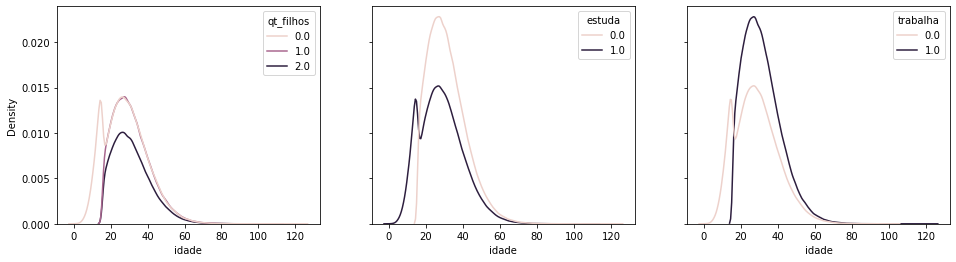

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.kdeplot(x='idade', hue='qt_filhos', data=ind_df_2, ax=ax[0])
sns.kdeplot(x='idade', hue='estuda', data=ind_df_2, ax=ax[1])
sns.kdeplot(x='idade', hue='trabalha', data=ind_df_2, ax=ax[2]);

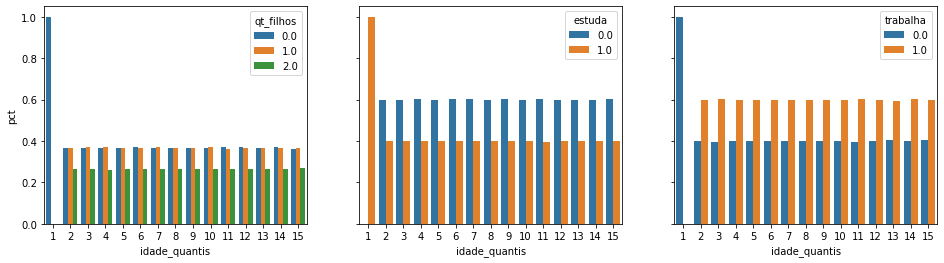

In [53]:
ind_df_2['idade_quantis'] = pd.qcut(ind_df_2['idade'], q=15, labels=range(1, 16))

filhos_df = (ind_df_2
             .groupby('idade_quantis')['qt_filhos']
             .value_counts(normalize=True)
             .rename('pct')
             .reset_index())
estuda_df = (ind_df_2
             .groupby('idade_quantis')['estuda']
             .value_counts(normalize=True)
             .rename('pct')
             .reset_index())
trabalha_df = (ind_df_2
               .groupby('idade_quantis')['trabalha']
               .value_counts(normalize=True)
               .rename('pct')
               .reset_index())

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.barplot(x='idade_quantis', y='pct', hue='qt_filhos', data=filhos_df, ax=ax[0])
sns.barplot(x='idade_quantis', y='pct', hue='estuda', data=estuda_df, ax=ax[1])
ax[1].set_ylabel('')
sns.barplot(x='idade_quantis', y='pct', hue='trabalha', data=trabalha_df, ax=ax[2])
ax[2].set_ylabel('');

In [54]:
ind_df_2.loc[ind_df_2['idade_quantis'] == 1, 'idade'].describe().T

count    64535.000000
mean        12.455629
std          2.397361
min          0.000000
25%         11.000000
50%         13.000000
75%         14.000000
max         15.000000
Name: idade, dtype: float64

In [55]:
ind_df_2_ = ind_df_2.query('idade_quantis > 1').copy(deep=True)

In [56]:
ind_df_2_.corr().round(3)

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,0.000,-0.000,-0.000,0.001
idade,-0.001,1.000,0.001,-0.001,-0.001,0.000,0.000
qt_filhos,0.000,0.001,1.000,0.000,-0.001,-0.001,-0.000
estuda,0.000,-0.001,0.000,1.000,-0.000,0.000,-0.000
trabalha,-0.000,-0.001,-0.001,-0.000,1.000,0.001,0.000
pratica_esportes,-0.000,0.000,-0.001,0.000,0.001,1.000,-0.002
IMC,0.001,0.000,-0.000,-0.000,0.000,-0.002,1.000


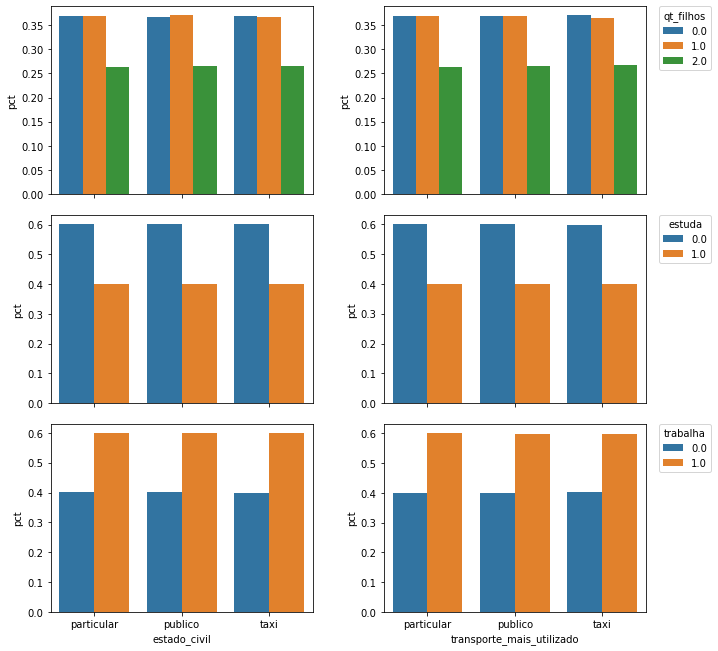

In [57]:
filhos_1 = (ind_df_2_
            .groupby('estado_civil')['qt_filhos']
            .value_counts(normalize=True)
            .rename('pct')
            .reset_index())
estuda_1 = (ind_df_2_
            .groupby('estado_civil')['estuda']
            .value_counts(normalize=True)
            .rename('pct')
            .reset_index())
trabalha_1 = (ind_df_2_
              .groupby('estado_civil')['trabalha']
              .value_counts(normalize=True)
              .rename('pct')
              .reset_index())
filhos_2 = (ind_df_2_
            .groupby('transporte_mais_utilizado')['qt_filhos']
            .value_counts(normalize=True)
            .rename('pct')
            .reset_index())
estuda_2 = (ind_df_2_
            .groupby('transporte_mais_utilizado')['estuda']
            .value_counts(normalize=True)
            .rename('pct')
            .reset_index())
trabalha_2 = (ind_df_2_
              .groupby('transporte_mais_utilizado')['trabalha']
              .value_counts(normalize=True)
              .rename('pct')
              .reset_index())

fig, ax = plt.subplots(3, 2, figsize=(9, 9), sharex=True)
fig.tight_layout(w_pad=4)

sns.barplot(x='estado_civil', y='pct', hue='qt_filhos', data=filhos_1, ax=ax[0, 0])
ax[0, 0].set_xlabel('')
ax[0, 0].get_legend().remove()
sns.barplot(x='transporte_mais_utilizado', y='pct', hue='qt_filhos', data=filhos_2, ax=ax[0, 1])
ax[0, 1].set_xlabel('')
ax[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='qt_filhos')

sns.barplot(x='estado_civil', y='pct', hue='estuda', data=estuda_1, ax=ax[1, 0])
ax[1, 0].set_xlabel('')
ax[1, 0].get_legend().remove()
sns.barplot(x='transporte_mais_utilizado', y='pct', hue='estuda', data=estuda_2, ax=ax[1, 1])
ax[1, 1].set_xlabel('')
ax[1, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='estuda')

sns.barplot(x='estado_civil', y='pct', hue='trabalha', data=trabalha_1, ax=ax[2, 0])
ax[2, 0].get_legend().remove()
sns.barplot(x='transporte_mais_utilizado', y='pct', hue='trabalha', data=trabalha_2, ax=ax[2, 1])
ax[2, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='trabalha');

In [58]:
filhos_pct_df = ind_df_2_['qt_filhos'].value_counts(normalize=True)
filhos_pct_df

0.0    0.367947
1.0    0.367709
2.0    0.264345
Name: qt_filhos, dtype: float64

In [59]:
mask = ind_df_2['qt_filhos'].isna()
ind_df_2.loc[mask & (ind_df_2['idade_quantis'] == 1), 'qt_filhos'] = 0
ind_df_2['qt_filhos'].fillna(sum(filhos_pct_df.index*filhos_pct_df.values), inplace=True)

In [60]:
estuda_pct_df = ind_df_2_['estuda'].value_counts(normalize=True)
estuda_pct_df

0.0    0.600262
1.0    0.399738
Name: estuda, dtype: float64

In [61]:
mask = ind_df_2['estuda'].isna()
ind_df_2.loc[mask & (ind_df_2['idade_quantis'] == 1), 'estuda'] = 1
ind_df_2['estuda'].fillna(sum(estuda_pct_df.index*estuda_pct_df.values), inplace=True)

In [62]:
trabalha_pct_df = ind_df_2_['trabalha'].value_counts(normalize=True)
trabalha_pct_df

1.0    0.599595
0.0    0.400405
Name: trabalha, dtype: float64

In [63]:
names_V1 = conn_df.loc[conn_df['grau'] == 'trabalho', 'V1'].unique()
names_V2 = conn_df.loc[conn_df['grau'] == 'trabalho', 'V2'].unique()
names = np.append(names_V1, names_V2)

mask = ind_df_2['trabalha'].isna()
ind_df_2.loc[mask & ind_df_2.index.isin(names), 'trabalha'] = 1
ind_df_2.loc[mask & (ind_df_2['idade_quantis'] == 1), 'trabalha'] = 0
ind_df_2['trabalha'].fillna(sum(trabalha_pct_df.index*trabalha_pct_df.values), inplace=True)

In [64]:
ind_df_2_['IMC_quantis'] = pd.qcut(ind_df_2_['IMC'], q=10, labels=range(1, 11))

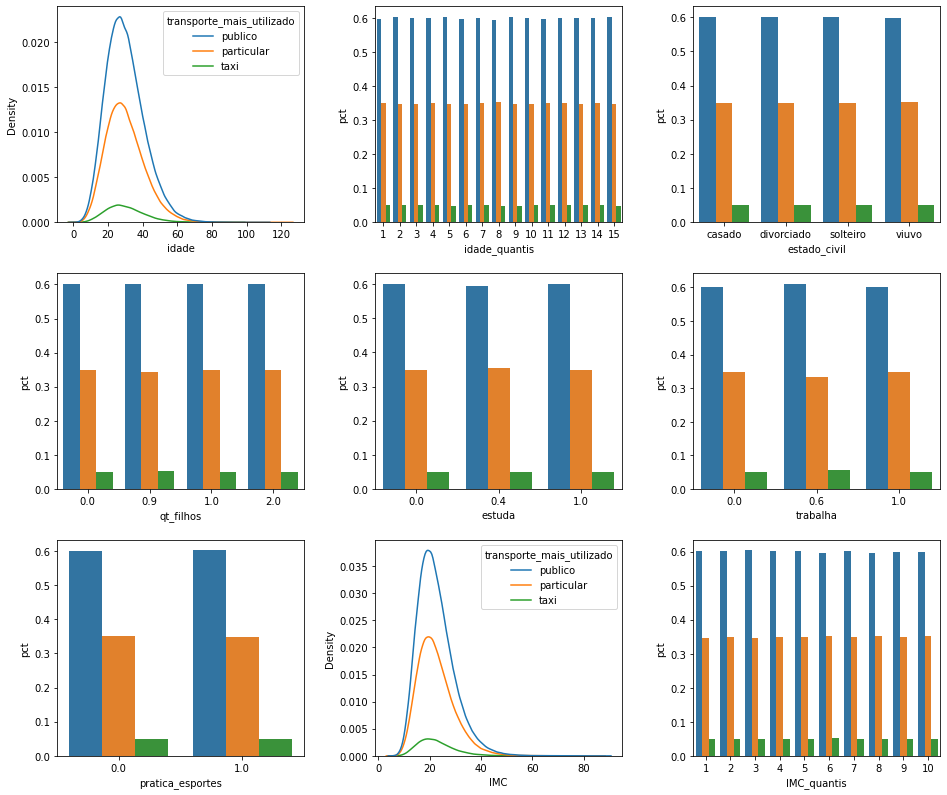

In [65]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11))
fig.tight_layout(h_pad=3, w_pad=4)

sns.kdeplot(x='idade', hue='transporte_mais_utilizado', data=ind_df_2, ax=ax[0, 0])

cols = ['idade_quantis', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'pratica_esportes']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['transporte_mais_utilizado']
           .value_counts(normalize=True)
           .rename('pct')
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='transporte_mais_utilizado', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in tmp[c].unique()])
    ax[n//3, n%3].get_legend().remove()

tmp = (ind_df_2_
       .groupby('IMC_quantis')['transporte_mais_utilizado']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())
sns.kdeplot(x='IMC', hue='transporte_mais_utilizado', data=ind_df_2, ax=ax[2, 1])
sns.barplot(x='IMC_quantis', y='pct', hue='transporte_mais_utilizado', data=tmp, ax=ax[2, 2])
ax[2, 2].get_legend().remove();

In [66]:
transp_pct_df = ind_df_2['transporte_mais_utilizado'].value_counts(normalize=True)
transp_pct_df

publico       0.600626
particular    0.349111
taxi          0.050263
Name: transporte_mais_utilizado, dtype: float64

In [67]:
ind_df_2['transporte_mais_utilizado'].fillna('outros', inplace=True)

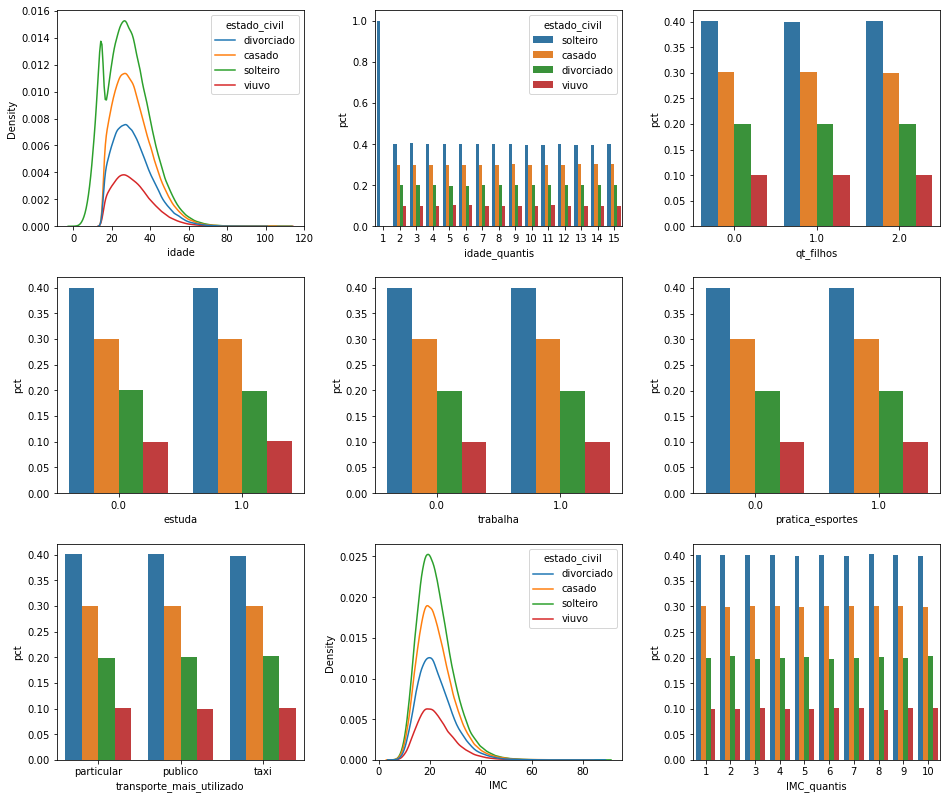

In [68]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11))
fig.tight_layout(h_pad=3, w_pad=4)

tmp = (ind_df_2
       .groupby('idade_quantis')['estado_civil']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())

sns.kdeplot(x='idade', hue='estado_civil', data=ind_df_2, ax=ax[0, 0])
sns.barplot(x='idade_quantis', y='pct', hue='estado_civil', data=tmp, ax=ax[0, 1])

cols = ['qt_filhos', 'estuda', 'trabalha', 'pratica_esportes', 'transporte_mais_utilizado']
for n, c in enumerate(cols, start=2):
    tmp = (ind_df_2_
           .groupby(c)['estado_civil']
           .value_counts(normalize=True)
           .rename('pct')
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='estado_civil', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in tmp[c].unique()])
    ax[n//3, n%3].get_legend().remove()

tmp = (ind_df_2_
       .groupby('IMC_quantis')['estado_civil']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())
sns.kdeplot(x='IMC', hue='estado_civil', data=ind_df_2_, ax=ax[2, 1])
sns.barplot(x='IMC_quantis', y='pct', hue='estado_civil', data=tmp, ax=ax[2, 2])
ax[2, 2].get_legend().remove();

In [69]:
estcv_pct_df = ind_df_2_['estado_civil'].value_counts(normalize=True)
estcv_pct_df

solteiro      0.399955
casado        0.300265
divorciado    0.199779
viuvo         0.100001
Name: estado_civil, dtype: float64

In [70]:
mask = ind_df_2['estado_civil'].isna()
ind_df_2.loc[mask & (ind_df_2['idade_quantis'] == 1), 'estado_civil'] = 'solteiro'
ind_df_2['estado_civil'].fillna('outros', inplace=True)

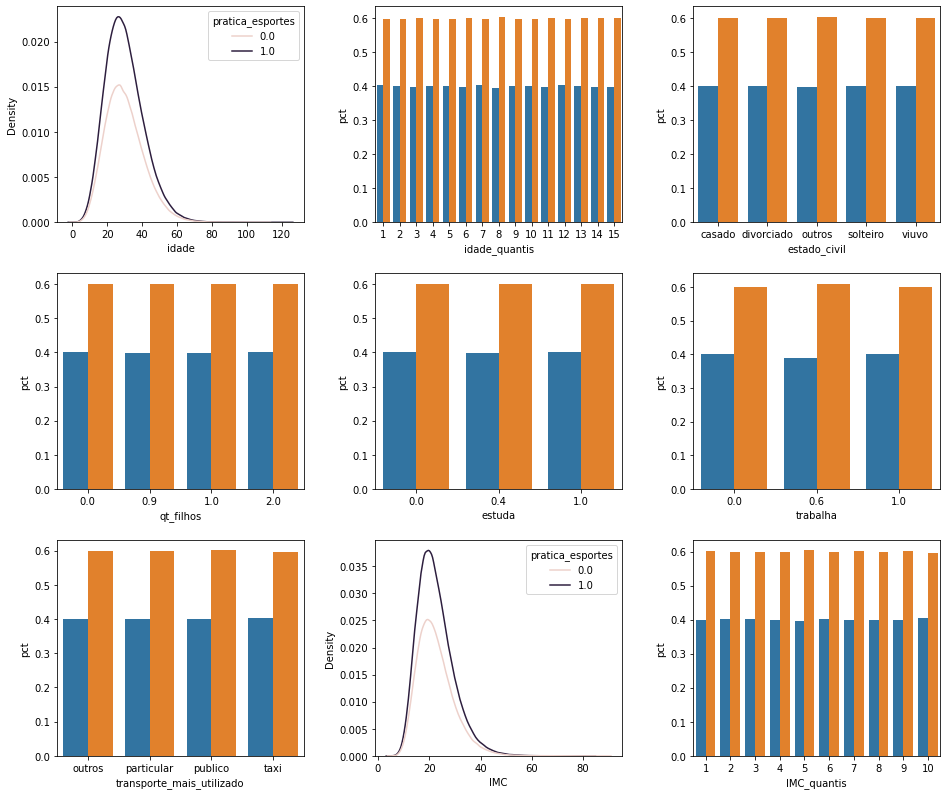

In [71]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11))
fig.tight_layout(h_pad=3, w_pad=4)

sns.kdeplot(x='idade', hue='pratica_esportes', data=ind_df_2, ax=ax[0, 0])

cols = ['idade_quantis', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'transporte_mais_utilizado']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['pratica_esportes']
           .value_counts(normalize=True)
           .rename('pct')
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='pratica_esportes', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in tmp[c].unique()])
    ax[n//3, n%3].get_legend().remove()

tmp = (ind_df_2_
       .groupby('IMC_quantis')['pratica_esportes']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())
sns.kdeplot(x='IMC', hue='pratica_esportes', data=ind_df_2, ax=ax[2, 1])
sns.barplot(x='IMC_quantis', y='pct', hue='pratica_esportes', data=tmp, ax=ax[2, 2])
ax[2, 2].get_legend().remove();

In [72]:
esportes_pct_df = ind_df_2_['pratica_esportes'].value_counts(normalize=True)
esportes_pct_df

1.0    0.600067
0.0    0.399933
Name: pratica_esportes, dtype: float64

In [73]:
mask = ind_df_2['pratica_esportes'].isna()
ind_df_2['pratica_esportes'].fillna(sum(esportes_pct_df.index*esportes_pct_df.values), inplace=True)

In [74]:
ind_df_2['IMC'].fillna(ind_df_2['IMC'].median(skipna=True), inplace=True)
ind_df_2['idade'].fillna(ind_df_2['idade'].median(skipna=True), inplace=True)

ind_df_2.drop('idade_quantis', axis=1, inplace=True)

In [75]:
df_2 = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V2'),
                conn_df, 
                how='right',
                left_on='name_V2', 
                right_on='V2')
df_2 = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V1'),
                df_2, 
                how='right',
                left_on='name_V1', 
                right_on='V1')
df_2 = df_2.drop(['V1', 'V2'], axis=1)
df_2

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,outros,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,2.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,21.431200,familia,visita_casual,0.451662
999997,499999,26.0,casado,2.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


In [76]:
scaler = MinMaxScaler()
pca = PCA(n_components=0.9, random_state=42)

df_2_ = pd.get_dummies(df_2.drop(cols_to_drop, axis=1), drop_first=True)
df_2_ = pca.fit_transform(scaler.fit_transform(df_2_))
pca_comps = [f'pc_{n+1}' for n in range(df_2_.shape[1])]
df_2_ = pd.DataFrame(scaler.fit_transform(df_2_), columns=pca_comps)

pd.Series(pca.explained_variance_ratio_, index=pca_comps).cumsum()

pc_1     0.088537
pc_2     0.176844
pc_3     0.249194
pc_4     0.318394
pc_5     0.384979
pc_6     0.451402
pc_7     0.501485
pc_8     0.551420
pc_9     0.599397
pc_10    0.644603
pc_11    0.689670
pc_12    0.732056
pc_13    0.774400
pc_14    0.804988
pc_15    0.835523
pc_16    0.861735
pc_17    0.887884
pc_18    0.910923
dtype: float64

In [77]:
df_2_ = df_2_.loc[:, :pca_comps[-1]]
df_2_['prob_V1_V2'] = df_2['prob_V1_V2']

df_2_

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,prob_V1_V2
0,0.427962,0.006012,0.649757,0.021893,0.509471,0.540605,0.770515,0.720718,0.990915,0.233881,0.347827,0.378538,0.031271,0.221548,0.577613,0.202525,0.368179,0.046748,0.589462
1,0.009618,0.574797,0.015360,0.016291,0.620986,0.372413,0.876600,0.552586,0.261020,0.200910,0.319851,0.374562,0.031264,0.546049,0.524681,0.319867,0.224619,0.043195,0.708465
2,0.424330,0.006434,0.979093,0.022175,0.482167,0.572918,0.587200,0.554398,0.058850,0.938473,0.485649,0.982190,0.366356,0.472412,0.214955,0.524063,0.605305,0.036137,NaN
3,0.427647,0.006813,0.008658,0.014366,0.675222,0.273912,0.579163,0.575809,0.230590,0.706514,0.285344,0.383183,0.012994,0.871024,0.147177,0.637015,0.468815,0.028130,0.638842
4,0.989755,0.427824,0.567959,0.512190,0.227907,0.584456,0.457231,0.319374,0.403403,0.703504,0.218844,0.970881,0.371833,0.450624,0.550204,0.346700,0.530877,0.978187,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,0.429489,0.005964,0.020545,0.028338,0.405989,0.699573,0.591881,0.373844,0.221601,0.253992,0.720331,0.033387,0.625552,0.389195,0.237621,0.530646,0.598505,0.035547,NaN
999995,0.010830,0.574787,0.020281,0.027127,0.408033,0.702064,0.592007,0.374232,0.221113,0.252702,0.720196,0.030584,0.625654,0.389671,0.236425,0.530781,0.597726,0.034584,NaN
999996,0.727881,0.227331,0.986266,0.980345,0.484191,0.687149,0.487513,0.709372,0.085855,0.501949,0.070691,0.008836,0.613141,0.497971,0.816439,0.733334,0.278201,0.026878,0.451662
999997,0.726648,0.228624,0.018961,0.979615,0.551504,0.580777,0.551705,0.549634,0.226832,0.961311,0.492757,0.032424,0.596622,0.277599,0.854446,0.474019,0.593024,0.031261,0.186973


In [78]:
df_2_.describe().T

,count,mean,std,min,25%,50%,75%,max
pc_1,999999.0,0.482540,0.325982,0.000000,0.298261,0.426423,0.723273,1.000000
pc_2,999999.0,0.383906,0.326346,0.000000,0.007607,0.424998,0.575509,1.000000
pc_3,999999.0,0.486633,0.407441,0.000000,0.021809,0.570435,0.972973,1.000000
pc_4,999999.0,0.499251,0.389616,0.000000,0.027977,0.499575,0.970560,1.000000
pc_5,999999.0,0.499911,0.194284,0.000000,0.362531,0.508740,0.641866,1.000000
pc_6,999999.0,0.496064,0.195405,0.000000,0.356494,0.503702,0.641641,1.000000
pc_7,999999.0,0.484352,0.179217,0.000000,0.356390,0.489030,0.610753,1.000000
pc_8,999999.0,0.452485,0.178449,0.000000,0.328052,0.454912,0.578405,1.000000
pc_9,999999.0,0.331683,0.319568,0.000000,0.075710,0.219566,0.414827,1.000000
pc_10,999999.0,0.496515,0.212403,0.000000,0.306456,0.495994,0.682295,1.000000


In [79]:
mask = df_2_['prob_V1_V2'].isna()
X_2_isna = df_2_.loc[mask].drop('prob_V1_V2', axis=1)
X_2_notna = df_2_.loc[~mask].drop('prob_V1_V2', axis=1)
y_2_notna = logit(df_2_.loc[~mask, 'prob_V1_V2'])

In [83]:
# %%time

# knn_reg_imp = KNeighborsRegressor(weights='distance', n_jobs=-1)

# knn_reg_imp.fit(X_2_notna, y_2_notna)

# df_2_.loc[mask, 'prob_V1_V2'] = logistic(knn_reg_imp.predict(X_2_isna))

In [84]:
df_2['prob_V1_V2'] = df_2_['prob_V1_V2']

X_2_, y_2 = df_2.drop(cols_to_drop, axis=1), df_2['prob_V1_V2']
X_2 = pd.get_dummies(X_2_, drop_first=True)

In [87]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2,
                                                            logit(y_2),
                                                            test_size=0.4,
                                                            random_state=42)

# lr_2_model = LinearRegression().fit(X_2_train, y_2_train)
lr_2_model = joblib.load('lr_2_model.pkl')

In [88]:
train_loss = cross_entropy_loss(y_2_train, lr_2_model.predict(X_2_train))
test_loss = cross_entropy_loss(y_2_test, lr_2_model.predict(X_2_test))

print('lr_2 train loss:', train_loss)
print('lr_2 test loss:', test_loss)

lr_2 train loss: 0.6575945308575337
lr_2 test loss: 0.657424732786195


In [89]:
df_raw_ = pd.get_dummies(df_raw.drop(['name_V1', 'name_V2'], axis=1), drop_first=True)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(df_raw_.drop('prob_V1_V2', axis=1),
                                                            logit(df_raw_['prob_V1_V2']),
                                                            test_size=0.4,
                                                            random_state=42)

In [90]:
lgbm_reg = lgb.LGBMRegressor(random_state=42)
lgbm_reg.fit(X_3_train, y_3_train);

In [93]:
train_loss = cross_entropy_loss(y_3_train, lgbm_reg.predict(X_3_train))
test_loss = cross_entropy_loss(y_3_test, lgbm_reg.predict(X_3_test))

print('lgbr train loss:', train_loss)
print('lgbr test loss:', test_loss)

lgbr train loss: 0.6489607855872174
lgbr test loss: 0.6490465650369334
